In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    classification_report
)

df=pd.read_csv('data/processed_data.csv')
X=df.drop(columns='preeclampsia')
y=df['preeclampsia']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

logreg=joblib.load('models/saved_models/LogisticRegression.pkl')
rf=joblib.load('models/saved_models/RandomForest.pkl')
svm=joblib.load('models/saved_models/SVM.pkl')
xgb=joblib.load('models/saved_models/XGBoost.pkl')

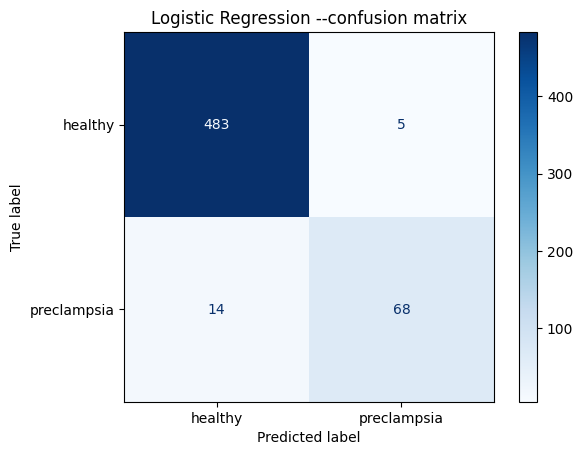

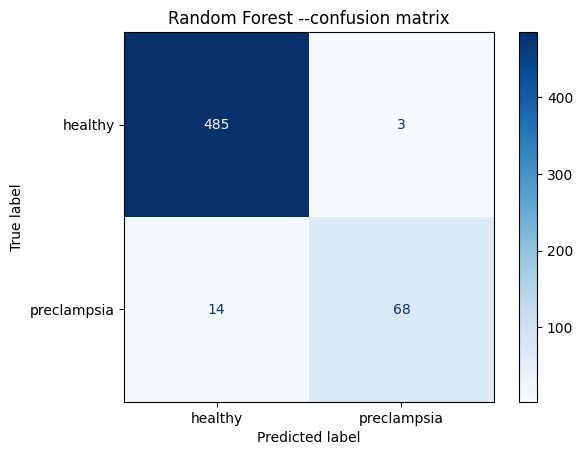

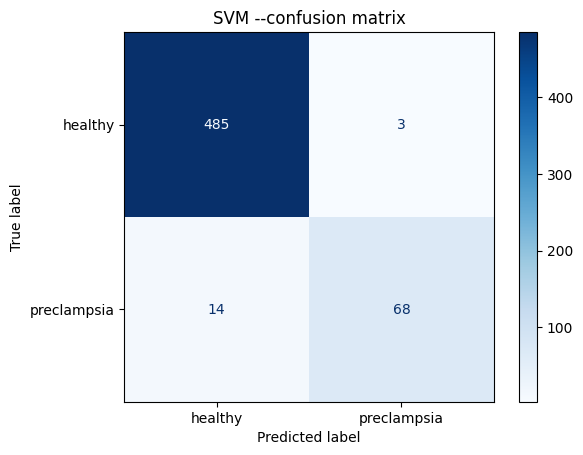

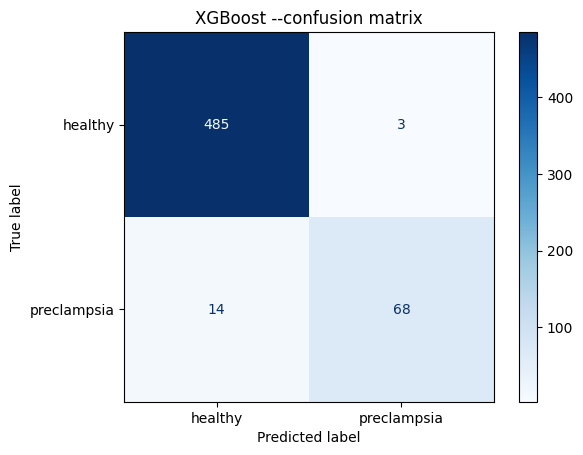

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

models={
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "SVM": svm,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["healthy", "preclampsia"], cmap='Blues'
    )
    plt.title(f"{name} --confusion matrix")
    plt.grid(False)
    plt.show()

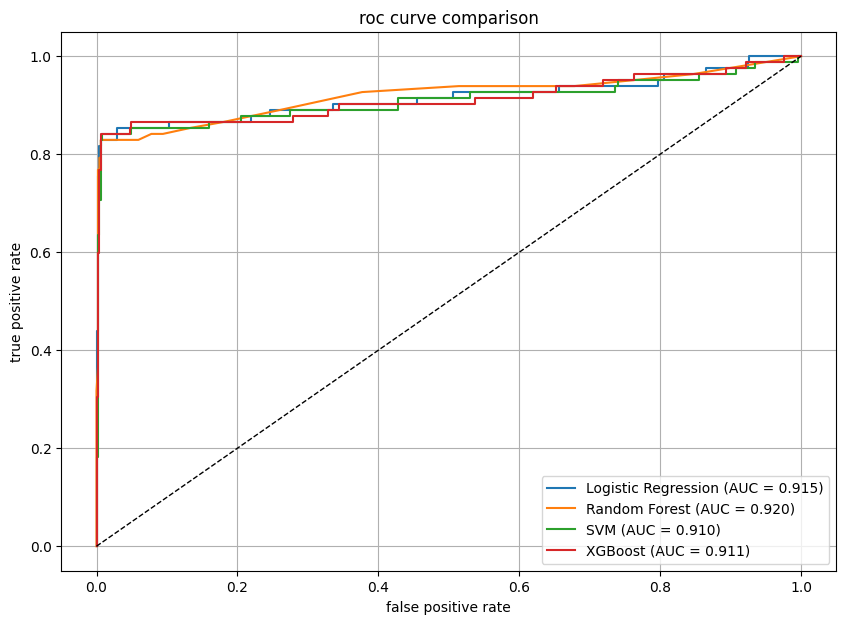

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("roc curve comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

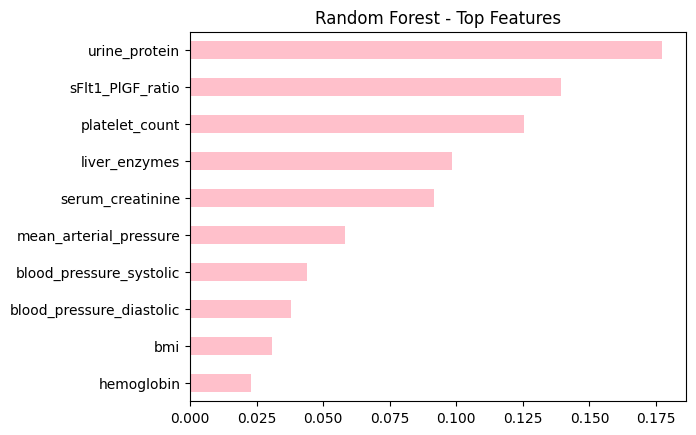

In [25]:
rf_importance=pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importance.head(10).plot(kind='barh', title="Random Forest - Top Features", color='pink')
plt.gca().invert_yaxis()
plt.show()

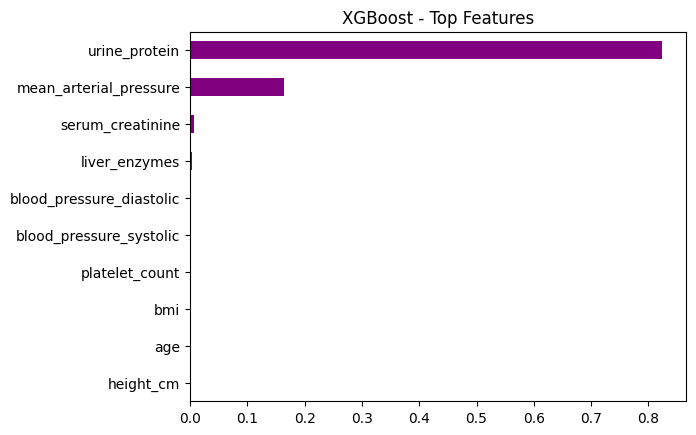

In [17]:
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_importance.head(10).plot(kind='barh', title="XGBoost - Top Features", color='purple')
plt.gca().invert_yaxis()
plt.show()

In [26]:
for name, model in models.items():
    print(f"{name} ----classification report")
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))
    print("-"*100)

Logistic Regression ----classification report
              precision    recall  f1-score   support

           0     0.9718    0.9898    0.9807       488
           1     0.9315    0.8293    0.8774        82

    accuracy                         0.9667       570
   macro avg     0.9517    0.9095    0.9291       570
weighted avg     0.9660    0.9667    0.9659       570

----------------------------------------------------------------------------------------------------
Random Forest ----classification report
              precision    recall  f1-score   support

           0     0.9719    0.9939    0.9828       488
           1     0.9577    0.8293    0.8889        82

    accuracy                         0.9702       570
   macro avg     0.9648    0.9116    0.9358       570
weighted avg     0.9699    0.9702    0.9693       570

----------------------------------------------------------------------------------------------------
SVM ----classification report
              precision    r

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

y = df['preeclampsia']
X = df.drop('preeclampsia', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


log_clf = LogisticRegression(max_iter=1000, random_state=42)
svm_clf = SVC(probability=True, kernel='rbf', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

ensemble_clf = VotingClassifier(
    estimators=[
        ('LogReg', log_clf),
        ('SVM', svm_clf),
        ('RF', rf_clf),
        ('XGB', xgb_clf)
    ],
    voting='soft'
)

ensemble_clf.fit(X_train, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test)
y_proba_ensemble = ensemble_clf.predict_proba(X_test)[:, 1]

print("ensemble model")
print(classification_report(y_test, y_pred_ensemble))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_ensemble))


C:\Users\sejal\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔷 Ensemble Model ----classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       488
           1       0.96      0.83      0.89        82

    accuracy                           0.97       570
   macro avg       0.96      0.91      0.94       570
weighted avg       0.97      0.97      0.97       570

AUC-ROC: 0.9077119152339064
